# Chapter 7.1: Pennies 1 (Revisiting the Second Law)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [ ]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

So far the differential equations we've worked with have been *first order*, which means they involve only first derivatives. In this
chapter, we turn our attention to *second order* differential equations, which can involve both first and second derivatives.

We'll revisit the falling penny example from Chapter 1, and use `run_solve_ivp` to find the position and velocity of the penny as it falls, with and without air resistance.

## The Second Law of Motion

First order differential equations (DEs) can be written 

$$\frac{dy}{dx} = G(x, y)$$ 

where $G$ is some function of $x$ and $y$ (see <http://modsimpy.com/ode>).  If the denominator is $dt$, then we call these rate equations: how fast is some variable changing with time?

Second order DEs can be written 

$$\frac{d^2y}{dx^2} = H(x, y, \frac{dy}{dt})$$

where $H$ is a function of $x$, $y$, and $dy/dx$.  While a first order DE tells us how fast a variable is changing, a second order DE tells us how fast a *rate* is changing.  

What does that mean?  In this chapter, we will work with one of the most famous and useful second order DEs, the second law of motion: 

$$F = m a$$ 

where $F$ is a force or the total of a set of forces, $m$ is the mass of a moving object, and $a$ is its acceleration.

This equation might not look like a differential equation, until we
realize that acceleration, $a$, is the second derivative of position,
$y$, with respect to time, $t$:

$$a = \frac{d^2y}{dt^2}$$ 

Subbing this into the second law, we can write:

$$\frac{d^2y}{dt^2} = F / m$$ 

Now you can see that the second law is a second order DE.  

While velocity tells us how the variable *position* is changing with time, acceleration tells us how fast *velocity* is changing with time.  It is the rate of change of velocity, or more fundamentally, it is the rate of change of the rate of change of position (!).  That makes it a second order DE.

Of course, this "law" is really a model in the sense that it is a
simplification of the real world. Although it is often approximately
true:

-   It only applies if $m$ is constant. If mass depends on time,
    position, or velocity, we have to use a more general form of
    the law (see <http://modsimpy.com/varmass>).

-   It is not a good model for very small things, which are better
    described by another model, quantum mechanics.

-   And it is not a good model for things moving very fast, which are
    better described by yet another model, relativistic mechanics.

However, for medium-sized things with constant mass, moving at
medium-sized speeds, Newton's model is extremely useful. If we can
quantify the forces that act on such an object, we can predict how it
will move.

## Dropping Pennies

As a first example, let's get back to the penny falling from the Empire State Building, which we considered in Chapter 1. We will implement two models of this system: first without air resistance, then with.

Given that the Empire State Building is 381 m high, and assuming that
the penny is dropped from a standstill, the initial conditions are:

In [ ]:
init = pd.Series(dict(y=381, v=0))

where `y` is height above the sidewalk and `v` is velocity. 

I'll put the initial conditions in a `System` object, along with the magnitude of acceleration due to gravity, `g`, and the duration of the simulations, `t_end`.

In [ ]:
system = dict(init=init, 
                g=9.8, 
                t_end=10)

Now we need a slope function, and here's where things get tricky. As we have seen, `run_solve_ivp` can solve systems of first order DEs, but the second law is a second order DE. However, if we recognize that

1.  Velocity, $v$, is the derivative of position, $dy/dt$, and

2.  Acceleration, $a$, is the derivative of velocity, $dv/dt$,

we can rewrite the second law as a system of first order ODEs:

$$\frac{dy}{dt} = v$$ 

$$\frac{dv}{dt} = a$$ 

This set of equations embodies the idea we mentioned earlier: acceleration is the rate of change of the rate of change of position.  

More concretely, this system allows us to translate the second law into a slope function:

In [ ]:
def slope_func(t, state, system):
    y, v = state

    dydt = v
    dvdt = -system['g']
    
    return dydt, dvdt

As usual, the parameters are a time stamp, a `state` object, and a `system` object.

The first line unpacks the state variables, `y` and `v`.

The next two lines compute the derivatives of the state variables, `dydt` and `dvdt`.
The derivative of position is velocity, and the derivative of velocity is acceleration.
In this case, $a = -g$, which indicates that acceleration due to gravity is in the direction of decreasing $y$. 

`slope_func` returns a sequence containing the two derivatives.

Before calling `run_solve_ivp`, it is a good idea to test the slope
function with the initial conditions:

In [ ]:
dydt, dvdt = slope_func(0, system['init'], system)
dydt, dvdt

(0, -9.8)

The result is 0 m/s for velocity and -9.8 m/s$^2$ for acceleration.

Now we call `run_solve_ivp` like this:

In [ ]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

`results` is a `DataFrame` with two columns: `y` contains the height of the penny; `v` contains its velocity.
Here are the first few rows.

In [ ]:
results.head()

,y,v
0.0,381.000,0.00
0.1,380.951,-0.98
0.2,380.804,-1.96
0.3,380.559,-2.94
0.4,380.216,-3.92


We can plot the results like this:

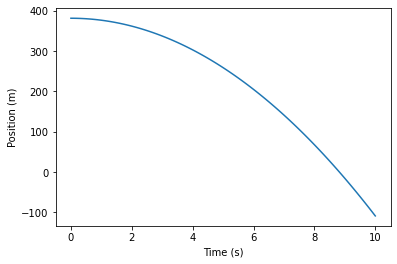

In [ ]:
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)');

Since acceleration is constant, velocity increases linearly and position decreases quadratically; as a result, the height curve is a parabola.

The last value of `results.y` is negative, which means we ran the simulation too long. 

In [ ]:
results.iloc[-1].y

-108.99999999999869

One way to solve this problem is to use the results to
estimate the time when the penny hits the sidewalk: we could keep running the simulation until the end `y` value was close to zero, or even write a code that would do that for us.

But there is a better way....

## Events

As an option, `run_solve_ivp` can take an *event function*, which
detects an "event", like the penny hitting the sidewalk, and ends the
simulation.  The "event" occurs when the assigned variable of a continuous function reaches 0.  See the `scipy` page on `solve_ivp` for information: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

Event functions take the same parameters as slope functions, `t`, `state`, and `system`. They should return a value that passes through `0` when the event occurs. Here's an event function that detects the penny hitting the sidewalk:

In [ ]:
def event_func(t, state, system):
    y, v = state
    return y

The return value is the height of the penny, `y`, which passes through
`0` when the penny hits the sidewalk.

We pass the event function to `run_solve_ivp` like this:

In [ ]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

The simulation stops when the value of `y` reaches zero.  That means that the last set of values (`t`,`y`,`v`) for `results` will be the values when the penney hits the ground.  So we can get the flight time like this:

In [ ]:
t_end = results.index[-1]
t_end

8.81788534972056

And the final velocity like this:

In [ ]:
y, v = results.iloc[-1]
y, v

(5.684341886080802e-14, -86.4152764272615)

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at about 86 m/s. So it's a good thing there is air resistance.

## Summary

In this chapter, we wrote the second law of motion, which is a second order DE, as a system of first order DEs.
Then we used `run_solve_ivp` to simulate a penny dropping from the Empire State Building in the absence of air resistance.
And we used an event function to stop the simulation when the penny reaches the sidewalk.

In the next chapter we'll add air resistance to the model.

### Exercise 1

Here's a question from the web site *Ask an Astronomer* (see http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

> "If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_solve_ivp` to answer this question.

Here are some suggestions about how to proceed:

1.  Look up the Law of Universal Gravitation and any constants you need.  I suggest you work entirely in SI units: meters, kilograms, and Newtons.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

4. Assume that the sun will not move a lot, so only need to consider the velocity and the position of the earth.   But if you'd like to challenge yourself, consider that the gravitational force would pull both on the earth and the sun: to be more accurate we'd need to consider the movement of both the earth and the sun.  If you do this, check at the end whether the assumption that the sun doesn't move much is valid.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.



In [ ]:
# Define an initial state and a system
r_earth = 6.378e6
r_sun = 6.9634e8
init_pE = 1.4722e11

init = pd.Series(dict(pE=init_pE, vE = 0, pS = 0, vS = 0))
system = dict(init=init,r_earth = r_earth,
                r_sun = r_sun,
                m_earth = 5.972e24,
                m_sun = 1.989e30, 
                G_constant = 6.674e-11,
                t_end=1e8)

In [ ]:
# Define a slope function
def slope_func(t, state, system):
    pE,vE,pS,vS = state
    
    G, mE, mS = system['G_constant'], system['m_earth'], system['m_sun']
    rE,rS = system['r_earth'], system['r_sun']
    d = pE - pS
    F = (G * mE * mS)/(d**2)

    dydt_E = vE
    dvdt_E = -F/mE
    
    dydt_S = vS
    dvdt_S = F/mS
    d_coll =  d - (rE + rS)
    
    return dydt_E, dvdt_E, dydt_S, dvdt_S

In [ ]:
# Test your slope function for the initial conditions
slope_func(0,init,system)

(0.0, -0.006124735788421156, 0.0, 1.8389603885596353e-08)

In [ ]:
# Define an appropriate event_func

def event_func(t, state, system):
    pE,vE,pS,vS = state
    return pE - pS - system['r_earth'] - system['r_sun']

In [ ]:
# Run run_solve_ivp
results, details = run_solve_ivp(system, slope_func,events=event_func)


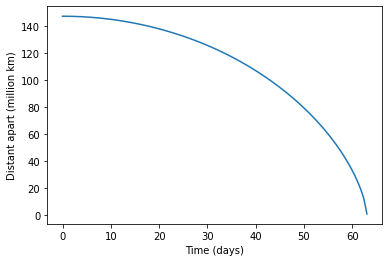

In [ ]:
# Plot the distance between the earth and the sun over time

# Find the distance between sun and earth in millions of kilometers
d_coll = (results.pE - results.pS)/1e9

# Convert index from seconds to days
d_coll.index = d_coll.index/(24 * 60 * 60)
d_coll.plot(xlabel='Time (days)',
         ylabel='Distant apart (million km)');

In [ ]:
# Determine the final values for the velocity of the earth
# and the time elapsed

pE,vE,pS,vS = results.iloc[-1]
print('When the sun and earth collide:')
print('   The earth has travelled ', (init_pE-pE)/(1e9), ' million km')
print('   The sun has travelled ', (pS)/(1e6), ' km')
print('   The sun has a velocity of ', vS, 'm/s')
print('   The earths velocity is ', -vE/1000, 'km/s')
print('   The time elapsed before the collision is ', 
      results.index[-1]/(24*3600), 'days')

# Notice that it would take a fraction of a second for the earth to 
# travel the additional 0.4 km that the sun travelled during the
# elapsed time.

When the sun and earth collide:
   The earth has travelled  146.51684208115648  million km
   The sun has travelled  0.43991884409686594  km
   The sun has a velocity of  1.8401106456798364 m/s
   The earths velocity is  612.8566768682513 km/s
   The time elapsed before the collision is  63.019009293692974 days
